# Predicting Purchases

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

plt.style.use('seaborn')

# Load datasets
train = pd.read_csv('/Users/waelismail/Desktop/train.csv')
test = pd.read_csv('/Users/waelismail/Desktop/test.csv')

%matplotlib inline

# EDA

## Preliminary Checks

In [2]:
# Explore train set
train.head()

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,...,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,61518,19297675,-1,6,928106152,2541203883,3606287998,306394936,2967512603,...,0,0,0,0,0,0,0,1083418268,3831440054,830706566
1,-1,356604,19320277,-1,12,3382400190,2018710401,1302581498,2308170622,2967512603,...,2,0,0,0,6,0,0,2993954402,2379633508,1284343215
2,-1,603441,19346318,-1,20,2569487005,2018710401,4121075497,2210625817,2967512603,...,0,0,0,0,0,0,0,1601090997,3617851689,4220791646
3,-1,192754,19308171,-1,9,2569487005,2018710401,3531445293,652481754,2967512603,...,0,0,0,0,0,0,0,4114483006,3617851689,4220791646
4,-1,210892,19309442,-1,9,1659166197,2018710401,1047694444,2210625817,2967512603,...,0,0,0,0,0,0,0,1971402551,2196958187,830706566


In [3]:
# View shape of the train set
print('The shape of the train dataframe is ', train.shape)

The shape of the train dataframe is  (31428, 27)


In [4]:
# Explore test set
test.head()

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,...,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,25540,19420446,-1,16,2569487005,2018710401,1429850909,2308170622,2967512603,...,0,0,0,0,0,0,0,1887882016,3617851689,4220791646
1,-1,29938,19431062,-1,19,1981742921,1235983246,4203734567,652481754,2116767313,...,0,0,0,0,0,0,0,3375463994,2379633508,1284343215
2,-1,9585,19392956,-1,8,2486871669,1235983246,2776175989,652481754,2116767313,...,0,0,0,0,0,0,0,3441876061,2196958187,1550397227
3,-1,23597,19416124,-1,15,3427628467,1235983246,4172481347,652481754,2116767313,...,0,0,0,0,0,0,0,2835356425,3831440054,1213938795
4,-1,27695,19425109,-1,17,2214885086,2541203883,3948279888,652481754,2967512603,...,0,0,0,0,0,0,0,1453469701,3831440054,830706566


In [5]:
# View shape of the train set
print('The shape of the test dataframe is ', test.shape)

The shape of the test dataframe is  (32086, 27)


In [6]:
# Make sure they have the same columns
if len(set(train.columns) - set(test.columns)) == 0:
    print('All Columns Match')
else:
    print("Columns Mismatch")

All Columns Match


## Missing Values

In [7]:
# View missing values summary
print('Missing Values Summary for train df:\n{}'.format('-'*50))
print(train.isna().sum())
print()
print('Missing Values Summary for test df:\n{}'.format('-'*50))
print(test.isna().sum())

Missing Values Summary for train df:
--------------------------------------------------
label           0
id              0
visitTime       0
purchaseTime    0
hour            0
C1              0
C2              0
C3              0
C4              0
C5              0
C6              0
C7              0
C8              0
N1              0
C9              0
N2              0
N3              0
N4              0
N5              0
N6              0
N7              0
N8              0
N9              0
N10             0
C10             0
C11             0
C12             0
dtype: int64

Missing Values Summary for test df:
--------------------------------------------------
label           0
id              0
visitTime       0
purchaseTime    0
hour            0
C1              0
C2              0
C3              0
C4              0
C5              0
C6              0
C7              0
C8              0
N1              0
C9              0
N2              0
N3              0
N4              0
N

Thankfully we have no NULLs.

## Data Types

In [8]:
# View column types
train.dtypes

label           int64
id              int64
visitTime       int64
purchaseTime    int64
hour            int64
C1              int64
C2              int64
C3              int64
C4              int64
C5              int64
C6              int64
C7              int64
C8              int64
N1              int64
C9              int64
N2              int64
N3              int64
N4              int64
N5              int64
N6              int64
N7              int64
N8              int64
N9              int64
N10             int64
C10             int64
C11             int64
C12             int64
dtype: object

Notes:
- The id column is an integer, but holds no quantitative value. 
- Purchase Time by definition has a causal relationship (necessary and sufficient) with purchase, and so we cannot use it to train the model.
- Visit Time in the miliseconds elapsed since midnight. The hour of day has already been recorded, which is what holds meaning, so we can drop this column as well. Hours should be treated as a categorical feature rather than a nominal one, simply because a visit at 23:00 will be interpreted as greater in value than one at 6:00.

In [9]:
# drop id, purchase time and visit time
train.drop(['id', 'purchaseTime', 'visitTime'], axis=1, inplace=True)
test.drop(['purchaseTime', 'visitTime'], axis=1, inplace=True)

## Numerical Columns

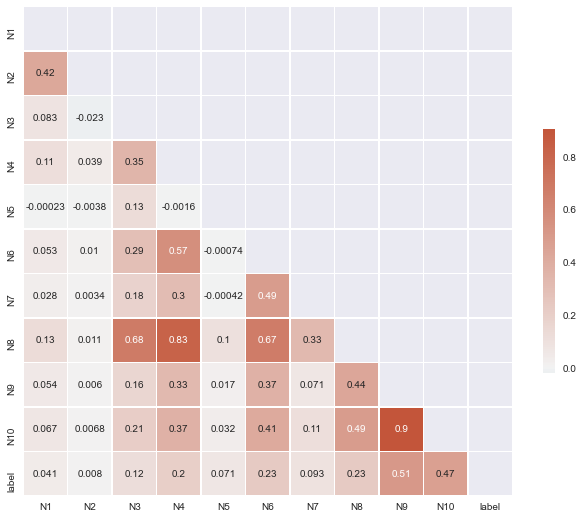

In [10]:
# Subset numerical columns
num_cols = [col for col in train.columns if col.startswith('N')] + ['label']

# Correlation matrix
corr = train[num_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=corr);

In [11]:
# Decribe numerical features
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
N1,31428.0,0.510882,1.157846,0.0,0.0,0.0,0.0,5.0
N2,31428.0,0.419594,1.681422,0.0,0.0,0.0,0.0,15.0
N3,31428.0,0.169849,1.286043,0.0,0.0,0.0,0.0,20.0
N4,31428.0,0.134307,1.258795,0.0,0.0,0.0,0.0,20.0
N5,31428.0,0.002386,0.156001,0.0,0.0,0.0,0.0,20.0
N6,31428.0,0.027269,0.562668,0.0,0.0,0.0,0.0,20.0
N7,31428.0,0.002164,0.079745,0.0,0.0,0.0,0.0,10.0
N8,31428.0,0.415680,3.184785,0.0,0.0,0.0,0.0,97.0
N9,31428.0,0.042319,1.008314,0.0,0.0,0.0,0.0,85.0
N10,31428.0,0.057560,1.158253,0.0,0.0,0.0,0.0,86.0


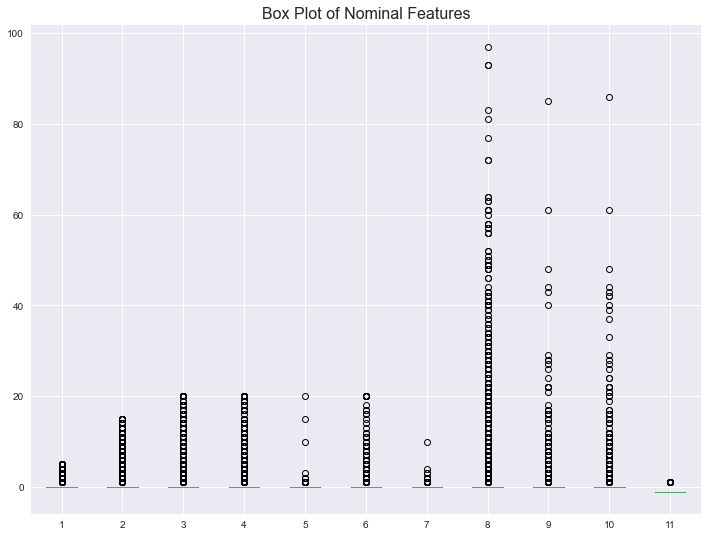

In [12]:
# Plot boxplot of nominal features
fig, ax = plt.subplots(figsize=(12, 9))
plt.boxplot(train[num_cols])
plt.title('Box Plot of Nominal Features', size=16);

As we can see there are a lot of outliers in all of the distributions for the numerical features.

## Categorical Columns

All columns are assigned int64 dtype, but some of them hold no quantitative value.

In [13]:
# Create list of categorical columns
cat_cols = [col for col in train.columns if col.startswith('C')]
cat_cols

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']

In [14]:
# View number of unique values for each column
print('Number of unique values for categorical columns in train set:\n{}'.format('-'*60))
print(train[cat_cols].nunique())

Number of unique values for categorical columns in train set:
------------------------------------------------------------
C1     22595
C2         8
C3      2863
C4         4
C5         3
C6        84
C7         6
C8        23
C9        60
C10    28653
C11       21
C12       19
dtype: int64


In [15]:
# View number of unique values for each column
print('Number of unique values for categorical columns in test set:\n{}'.format('-'*60))
print(test[cat_cols].nunique())

Number of unique values for categorical columns in test set:
------------------------------------------------------------
C1     22860
C2         8
C3      2798
C4         4
C5         3
C6        82
C7         6
C8        25
C9        59
C10    29700
C11       25
C12       22
dtype: int64


In [16]:
# Create dummies for train set
for col in cat_cols:
    thresh = train.shape[0] * 0.01
    mask = train[col].value_counts().values > thresh
    list_possible = train[col].value_counts()[mask].index
    train_mask = train[col].isin(list_possible)
    test_mask = test[col].isin(list_possible)
    train[col][~train_mask] = 'other'
    test[col][~test_mask] = 'other'

# Create DF with dummies
train = pd.get_dummies(train, columns=cat_cols + ['hour'])
test = pd.get_dummies(test, columns=cat_cols + ['hour'])

<ipython-input-16-c236673cefb2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col][~train_mask] = 'other'
<ipython-input-16-c236673cefb2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][~test_mask] = 'other'


Verify that columns match.

In [17]:
# Find any missing column
print('The missing column is: ', set(train.columns) - set(test.columns))

The missing column is:  {'C9_2711086415'}


In [18]:
# Add it to the test set will all zeros since the value doesnt appear in the test test
test['C9_2711086415'] = 0

In [19]:
# Verify shapes
print('Train set shape: ', train.shape)
print('Test set shape: ', test.shape)

Train set shape:  (31428, 143)
Test set shape:  (32086, 144)


There is one column that doesnt match because we droped 'id' from the training set. 

## Target Variable

In [20]:
# View class balance
class_balance = train['label'].value_counts(normalize=True)
print('Target Label Summary: \n{}'.format('-'*50))
print(class_balance)

Target Label Summary: 
--------------------------------------------------
-1    0.998186
 1    0.001814
Name: label, dtype: float64


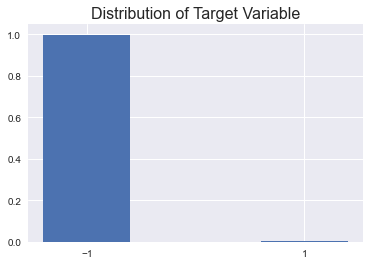

In [21]:
# Plot class balance
plt.bar(class_balance.index, class_balance.values)
plt.xticks([-1, 1])
plt.title('Distribution of Target Variable', size=16);

As we can see, the target variable is extremely unbalanced. In fact, we would get 99.8% accuracy just by predicting a negative.

## Scaling

In [22]:
# Scale only columns that have values greater than 1
to_scale = [col for col in train.columns if train[col].max() > 1]
mms = MinMaxScaler()
mms.fit(train[to_scale])
scaled_train = mms.transform(train[to_scale])
scaled_train = pd.DataFrame(scaled_train, columns=to_scale)
scaled_test = mms.transform(test[to_scale])
scaled_test = pd.DataFrame(scaled_test, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled_train:
    train[col] = scaled_train[col]

for col in scaled_test:
    test[col] = scaled_test[col]
    
train.head()

,label,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0.2,0.0,0.2,0.1,0.0,0.0,0.0,0.061856,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,1,0,0,0
3,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
test.head()

,label,id,N1,N2,N3,N4,N5,N6,N7,N8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,C9_2711086415
0,-1,25540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,-1,29938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,-1,9585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,-1,23597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,-1,27695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


## SMOTE

### Train test split

In [24]:
X = train.drop(['label'], axis=1)
y = train['label']

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (31428, 142)
Shape of X after SMOTE: (62742, 142)

Balance of positive and negative classes (%):


-1    50.0
 1    50.0
Name: label, dtype: float64

## Modeling

In [25]:
# Fit multiple classifiers on dataset with important features and see which one performs best 
names = ["Nearest Neighbors", "Decision Tree", 
         "Random Forest", 'Extra Trees', 
         "AdaBoost", 'Support Vector Machines']

classifiers = [ KNeighborsClassifier(5, n_jobs=-1), DecisionTreeClassifier(max_depth=10),
                RandomForestClassifier(max_depth=70, n_estimators=2000, n_jobs=5, min_samples_leaf=40, min_samples_split=80),
                ExtraTreesClassifier(max_depth=70, n_estimators=10, n_jobs=-1),
                AdaBoostClassifier(), SVC(C=0.5)]

train_accuracies = []
test_accuracies = []
train_recall = []
test_recall = []

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_train_prediction = clf.predict(X_train)
    y_test_prediction = clf.predict(X_test)
    
    train_accuracies.append(accuracy_score(y_train, y_train_prediction))
    test_accuracies.append(accuracy_score(y_test, y_test_prediction))
    train_recall.append(recall_score(y_train, y_train_prediction))
    test_recall.append(recall_score(y_test, y_test_prediction))

results = pd.DataFrame({'Classifier': names, 
                        'Train Accuracy': train_accuracies, 
                        'Train Recall': train_recall, 
                        'Test Accuracy': test_accuracies, 
                        'Test Recall': test_recall})
results

,Classifier,Train Accuracy,Train Recall,Test Accuracy,Test Recall
0,Nearest Neighbors,0.996387,0.999574,0.995410,0.999241
1,Decision Tree,0.999447,0.999872,0.997960,0.999241
2,Random Forest,0.996685,0.999830,0.995920,0.999747
3,Extra Trees,0.999936,0.999872,0.999299,0.998862
4,AdaBoost,0.998704,0.999574,0.998151,0.999241
5,Support Vector Machines,0.999192,0.998380,0.998789,0.997597


We should select Random Forest Classifier.

## Generate Predictions on Test DF

In [26]:
# Instantiate Model
rcf = RandomForestClassifier(max_depth=70, n_estimators=100, n_jobs=5, min_samples_leaf=40, min_samples_split=80)

# Fit the model
rcf.fit(X_train, y_train)

X_submission = test.drop(['label', 'id'], axis=1)

# Generate predictions
y_submission_pred = rcf.predict_proba(X_submission)

In [27]:
# Generate dataframe
purchase_prob = [b for (a, b) in y_submission_pred]
    
data = {"Id":  test["id"].to_list(),'Prob': purchase_prob}

df_submission = pd.DataFrame(data)

In [28]:
df_submission.head()

,Id,Prob
0,25540,0.097966
1,29938,0.066062
2,9585,0.015615
3,23597,0.022663
4,27695,0.102295


In [29]:
df_submission.to_csv('/Users/waelismail/Desktop/ML_python_Results.csv', index=False)